In this notebook I am going to share an agumentation resource for object detection that I found from this [awesome project](https://github.com/ultralytics/yolov3). It has a variety of selection to play. We can tweak around with it to get a very high score.

# import libraries

In [6]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = './dataset'
DIR_TRAIN = f'{DIR_INPUT}/global-wheat-detection/train'
DIR_TEST = f'{DIR_INPUT}/global-wheat-detection/test'

# Load data for testing

In [7]:
train_df = pd.read_csv(f'{DIR_INPUT}/global-wheat-detection/train.csv')
train_df.shape

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-1:]
train_ids = image_ids #[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

# Create a test dataset
This part is based on [Peter's notebook](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train). For training you will need to modify this Datasetloader

In [9]:
from sklearn.utils import shuffle
import random
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.df = dataframe
        self.image_ids = dataframe['image_id'].unique()
        self.image_ids = shuffle(self.image_ids)
        self.labels = [np.zeros((0, 5), dtype=np.float32)] * len(self.image_ids)
        self.img_size = 1024
        im_w = 1024
        im_h = 1024
        for i, img_id in enumerate(self.image_ids):
            records = self.df[self.df['image_id'] == img_id]
            boxes = records[['x', 'y', 'w', 'h']].values
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            boxesyolo = []
            for box in boxes:
                x1, y1, x2, y2 = box
                xc, yc, w, h = 0.5*x1/im_w+0.5*x2/im_w, 0.5*y1/im_h+0.5*y2/im_h, abs(x2/im_w-x1/im_w), abs(y2/im_h-y1/im_h)
                boxesyolo.append([0, xc, yc, w, h])
            self.labels[i] = np.array(boxesyolo)
        
        self.image_dir = image_dir
        self.transforms = transforms
        
        self.mosaic = False
        self.augment = True

    def __getitem__(self, index: int):

        #img, labels = load_mosaic(self, index)
        self.mosaic = True
        if random.randint(0,1) ==0:
            self.mosaic = False
        if self.mosaic:
            # Load mosaic
            img, labels = load_mosaic(self, index)
            shapes = None

        else:
            # Load image
            img, (h0, w0), (h, w) = load_image(self, index)

            # Letterbox
            shape = self.img_size  # final letterboxed shape
            img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
            shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

            # Load labels
            labels = []
            x = self.labels[index]
            if x.size > 0:
                # Normalized xywh to pixel xyxy format
                labels = x.copy()
                labels[:, 1] = ratio[0] * w * (x[:, 1] - x[:, 3] / 2) + pad[0]  # pad width
                labels[:, 2] = ratio[1] * h * (x[:, 2] - x[:, 4] / 2) + pad[1]  # pad height
                labels[:, 3] = ratio[0] * w * (x[:, 1] + x[:, 3] / 2) + pad[0]
                labels[:, 4] = ratio[1] * h * (x[:, 2] + x[:, 4] / 2) + pad[1]
        
        if self.augment:
            # Augment imagespace
            if not self.mosaic:
                img, labels = random_affine(img, labels,
                                            degrees=0,
                                            translate=0,
                                            scale=0,
                                            shear=0)

            # Augment colorspace
            augment_hsv(img, hgain=0.0138, sgain= 0.678, vgain=0.36)
            
        return img, labels

    def __len__(self) -> int:
        return self.image_ids.shape[0]

# Augmentation functions
All of the bellow functions I just copy from [author's repo](https://github.com/ultralytics/yolov3). Thank you for publishing your amazing works.

In [10]:
def load_image(self, index):
    # loads 1 image from dataset, returns img, original hw, resized hw
    image_id = self.image_ids[index]
    imgpath = f'{DIR_INPUT}/global-wheat-detection/train'
    img = cv2.imread(f'{imgpath}/{image_id}.jpg', cv2.IMREAD_COLOR)
    
    assert img is not None, 'Image Not Found ' + imgpath
    h0, w0 = img.shape[:2]  # orig hw
    return img, (h0, w0), img.shape[:2]  # img, hw_original, hw_resized

In [11]:
def load_mosaic(self, index):
    # loads images in a mosaic

    labels4 = []
    s = self.img_size
    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
    for i, index in enumerate(indices):
        # Load image
        img, _, (h, w) = load_image(self, index)

        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # Labels
        x = self.labels[index]
        labels = x.copy()
        if x.size > 0:  # Normalized xywh to pixel xyxy format
            labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
            labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
            labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
            labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
        labels4.append(labels)

    # Concat/clip labels
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
        # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
        np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

    # Augment
    # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
    img4, labels4 = random_affine(img4, labels4,
                                  degrees=1.98 * 2,
                                  translate=0.05 * 2,
                                  scale=0.05 * 2,
                                  shear=0.641 * 2,
                                  border=-s // 2)  # border to remove

    return img4, labels4

In [12]:
def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

    if targets is None:  # targets = [cls, xyxy]
        targets = []
    height = img.shape[0] + border * 2
    width = img.shape[1] + border * 2

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Combined rotation matrix
    M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
    if (border != 0) or (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

    # Transform label coordinates
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(n, 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # # apply angle-based reduction of bounding boxes
        # radians = a * math.pi / 180
        # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
        # x = (xy[:, 2] + xy[:, 0]) / 2
        # y = (xy[:, 3] + xy[:, 1]) / 2
        # w = (xy[:, 2] - xy[:, 0]) * reduction
        # h = (xy[:, 3] - xy[:, 1]) * reduction
        # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        w = xy[:, 2] - xy[:, 0]
        h = xy[:, 3] - xy[:, 1]
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
        i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

In [13]:
def augment_hsv(img, hgain=0.5, sgain=0.5, vgain=0.5):
    r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    dtype = img.dtype  # uint8

    x = np.arange(0, 256, dtype=np.int16)
    lut_hue = ((x * r[0]) % 180).astype(dtype)
    lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
    lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

    img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
    cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed


In [14]:
def letterbox(img, new_shape=(416, 416), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = new_shape
        ratio = new_shape[0] / shape[1], new_shape[1] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Show some samples

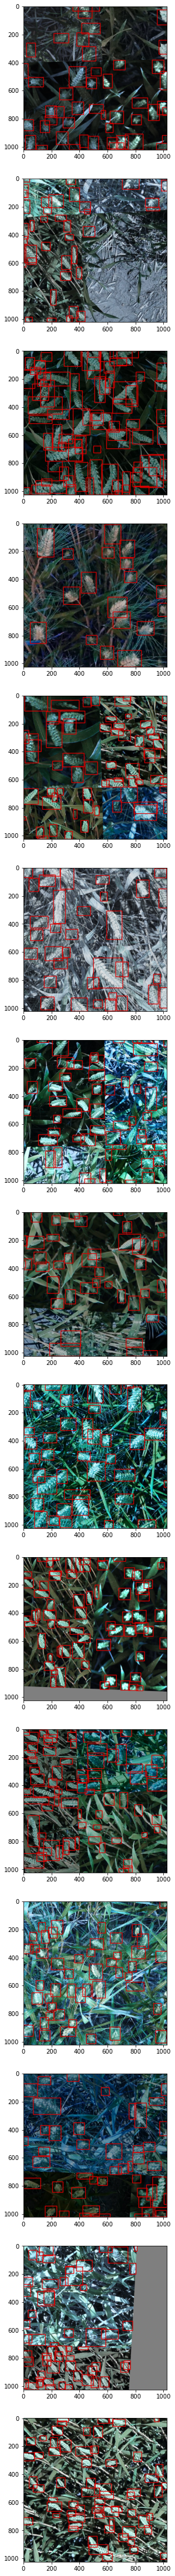

In [18]:
import random, math
# Albumentations
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

#train_dataset = WheatDataset(train_df, DIR_TRAIN, get_augumentation(phase='train'))

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)


fig, ax = plt.subplots(15, 1, figsize=(160, 80))
images, targets = next(iter(train_data_loader))
for i in range(15):  
    boxes = targets[i]
    sample = images[i]

    for box in boxes:
        cv2.rectangle(sample,
                  (int(box[1]), int(box[2])),
                  (int(box[3]), int(box[4])),
                  220, 3)

    ax[i].imshow(sample)
plt.show()